# Lab 1 - Análisis Exploratorio, PCA y Apriori
Ana Sofía Escobar - 20489

In [165]:
##librerias a importar
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import seaborn as sns
import scipy.stats as stats
from ydata_profiling import ProfileReport
import pandas as pd
from apyori import apriori

In [673]:
##Leer archivo

data = pd.read_csv('risk_factors_cervical_cancer.csv', encoding = "ISO-8859-1")
data.head()
col = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
       'Smokes (years)', 'Hormonal Contraceptives (years)']
data[col] = data[col].replace('?', 0)
data[col] = data[col].astype(float)


### Analisis Exploratorio

In [695]:
profile = ProfileReport(data)
profile.to_file("AnalisisExploratorio.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


In [696]:
def determinar_tipo_variable(datos):
    tipo_variable = None
    
    # Verificar si es una variable categórica
    if datos.dtype == 'object' or pd.api.types.is_categorical_dtype(datos):
        tipo_variable = "Categórica"
    # Verificar si es una variable cuantitativa continua
    elif pd.api.types.is_numeric_dtype(datos) and np.issubdtype(datos.dtype, np.floating):
        tipo_variable = "Cuantitativa Continua"
    # Verificar si es una variable cuantitativa discreta
    elif pd.api.types.is_numeric_dtype(datos) and np.issubdtype(datos.dtype, np.integer):
        tipo_variable = "Cuantitativa Discreta"
    
    return tipo_variable

for columna in data.columns:
    tipo = determinar_tipo_variable(data[columna])
    print(f"'{columna}' es: {tipo}")

'Age' es: Cuantitativa Discreta
'Number of sexual partners' es: Cuantitativa Continua
'First sexual intercourse' es: Cuantitativa Continua
'Num of pregnancies' es: Cuantitativa Continua
'Smokes' es: Categórica
'Smokes (years)' es: Cuantitativa Continua
'Smokes (packs/year)' es: Categórica
'Hormonal Contraceptives' es: Categórica
'Hormonal Contraceptives (years)' es: Cuantitativa Continua
'IUD' es: Categórica
'IUD (years)' es: Categórica
'STDs' es: Categórica
'STDs (number)' es: Categórica
'STDs:condylomatosis' es: Categórica
'STDs:cervical condylomatosis' es: Categórica
'STDs:vaginal condylomatosis' es: Categórica
'STDs:vulvo-perineal condylomatosis' es: Categórica
'STDs:syphilis' es: Categórica
'STDs:pelvic inflammatory disease' es: Categórica
'STDs:genital herpes' es: Categórica
'STDs:molluscum contagiosum' es: Categórica
'STDs:AIDS' es: Categórica
'STDs:HIV' es: Categórica
'STDs:Hepatitis B' es: Categórica
'STDs:HPV' es: Categórica
'STDs: Number of diagnosis' es: Cuantitativa Discre

### Analisis de componentes principales

C:\Users\anaso\AppData\Local\Temp\ipykernel_10956\4255193790.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


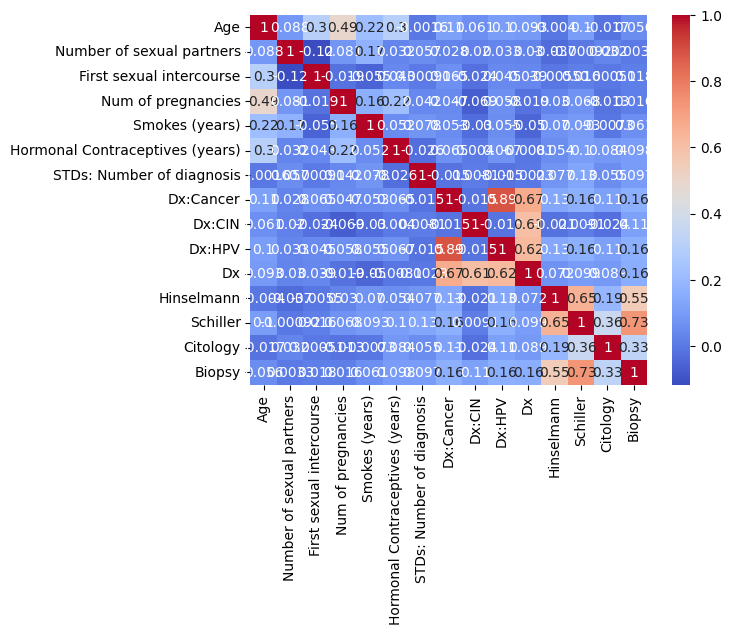

In [697]:
# Matriz de correlación para evaluar las correlaciones entre variables numéricas
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Para la matriz de correlación observamos que claramente si hay correlación entre las varibales cuantitativas, entre las correlaciones podemos observar que existe una correlación entre el cancer y el diganostico de HPV 

In [698]:
#obtener las variables numericas
cuantitativas = data.select_dtypes(include=['int64', 'float64'])

In [699]:
#test de esfeciridad
chi_cuadrado, p_valor = calculate_bartlett_sphericity(cuantitativas)
chi_cuadrado, p_valor

(4827.381497092617, 0.0)

El p-valor es menor que 0.05, por lo que se rechaza la hipótesis nula. Hay correlación entre las variables.

In [700]:
#indice de KMO
kmo,kmo_modelo = calculate_kmo(cuantitativas)
kmo_modelo

c:\Users\anaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6036095239529218

El índice es mayor a 0.5, por lo que la adecuación muestral para un análisis factorial es aceptable. Probablemente esto nos indique que podría tener buenos resultados haciendo el PCA, por lo que procedemos a realizarlo a continuación.

In [701]:
pca_pipe = make_pipeline(StandardScaler(),PCA()) #Se escalan los datos y luego se le aplica PCA
pca_pipe.fit(cuantitativas)
#Se extrae el modelo del pipeline
modelo_pca = pca_pipe.named_steps['pca']

#Se convierte el arreglo en data frame
pd.DataFrame(
    data = modelo_pca.components_,
    columns = cuantitativas.columns,
    index = ['PC1','PC2','PC3','PC4','PC5','PC6', 'PC7','PC8', 'PC9', 'PC10', 'PC11', 'PC12','PC13','PC14', 'PC15']
)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Hormonal Contraceptives (years),STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
PC1,0.148392,0.034423,0.053063,0.089942,0.081011,0.116114,0.060519,0.411067,0.122452,0.404499,0.370489,0.325286,0.390698,0.228126,0.383186
PC2,0.031514,0.015101,0.046986,-0.038096,-0.078637,-0.060569,-0.132983,0.372395,0.204040,0.360788,0.426290,-0.367481,-0.410954,-0.212752,-0.355236
PC3,0.590063,0.167767,0.174272,0.539164,0.306037,0.359031,0.013041,-0.021822,-0.126900,-0.018243,-0.136378,-0.119735,-0.071066,-0.105025,-0.118112
PC4,0.143565,0.125823,-0.046474,0.022961,0.013864,0.041857,0.118901,-0.326216,0.787756,-0.338024,0.290546,-0.034993,0.025153,-0.062936,0.115402
PC5,-0.198693,0.568614,-0.595862,0.055750,0.429046,-0.156178,0.228830,0.063937,-0.054978,0.080107,-0.006731,-0.029215,-0.034859,-0.004223,-0.050447
PC6,0.072487,-0.049811,0.462471,-0.102308,0.198014,-0.434411,0.710461,0.032850,-0.051145,0.019696,0.004096,0.003649,0.002588,-0.173453,-0.032181
PC7,0.040190,-0.288372,-0.101796,0.083055,0.377697,-0.329115,-0.397539,0.002377,0.054338,0.004465,0.000776,0.306560,0.091068,-0.614859,0.075191
PC8,0.082684,0.501404,0.465145,-0.360206,0.263606,-0.213377,-0.474202,-0.039741,0.000244,-0.052468,-0.032611,-0.050235,0.019017,0.211127,0.053927
PC9,0.102556,0.443496,0.024674,0.358355,-0.649367,-0.382661,-0.057261,-0.007784,-0.088658,-0.004642,0.007070,0.146897,0.083858,-0.229366,0.056293
PC10,-0.119915,0.303757,0.120225,-0.393168,-0.109165,0.563807,0.129421,0.044223,-0.044527,0.042769,-0.054858,0.195381,0.020673,-0.572165,0.054956


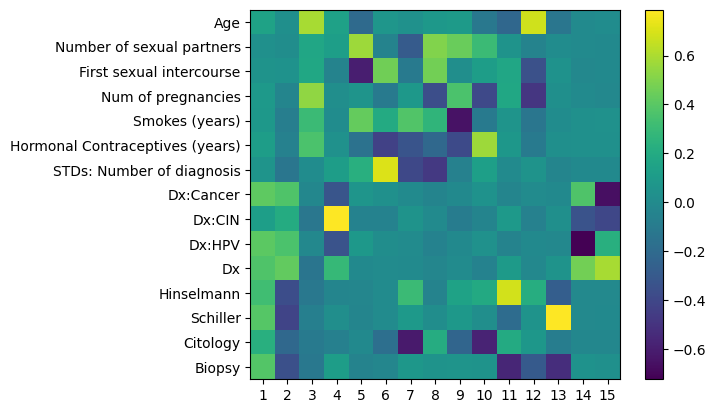

In [702]:
## Representación de cada variable en las diferentes componentes
fig, ax = plt.subplots(nrows=1, ncols=1)
componentes = modelo_pca.components_
plt.imshow(componentes.T)
plt.yticks(range(len(cuantitativas.columns)), cuantitativas.columns)
plt.xticks(range(len(cuantitativas.columns)), np.arange(modelo_pca.n_components_)+1)
plt.grid(False)
plt.colorbar();

In [703]:
#### Porcentaje de la varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente:')
print('')
print(modelo_pca.explained_variance_ratio_)

Porcentaje de varianza explicada por cada componente:

[0.20162678 0.13902326 0.11970829 0.08472974 0.08345477 0.06727583
 0.06094665 0.05866532 0.05056087 0.05020273 0.02890123 0.02495267
 0.01563297 0.00892591 0.00539298]


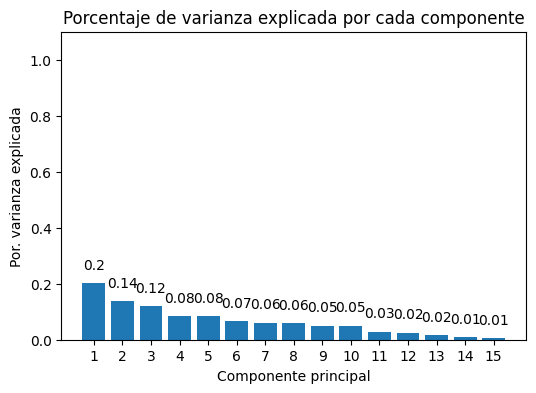

In [704]:
#### Scree plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(cuantitativas.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

Los primeros componentes explican la mayoría de la varianza y son los más informativos, mientras que los últimos componentes explican una cantidad menor de varianza y pueden tener menos relevancia en el análisis. 

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.20162678 0.34065004 0.46035833 0.54508807 0.62854284 0.69581867
 0.75676532 0.81543064 0.86599151 0.91619425 0.94509548 0.97004814
 0.98568111 0.99460702 1.        ]


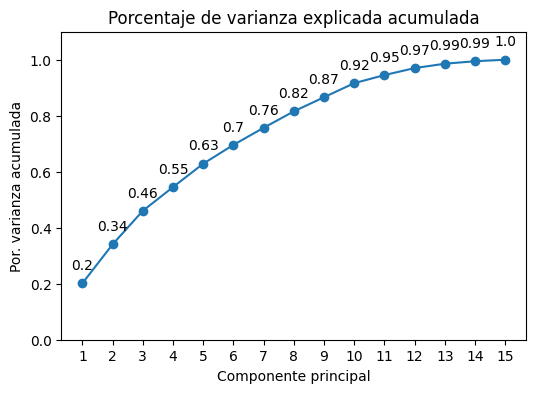

In [705]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(cuantitativas.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(cuantitativas.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Al utilizar todos los componentes principales (el 100% de varianza acumulada), se conserva la totalidad de la varianza original, lo que significa que no se pierde información en el proceso de reducción de dimensionalidad. Sin embargo, es posible que no todos los componentes sean igualmente informativos o relevantes para el análisis, esto se observa debido a que solo en los primeros 5 componentes principales se conserva más del 50% de varianza acumulada lo cual es cantidad significativa de la varianza original.

### Reglas de asociación

In [706]:
categoricas = data.select_dtypes(include=['object', 'category'])
categoricas = categoricas.astype(object)
categoricas

,Smokes,Smokes (packs/year),Hormonal Contraceptives,IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Time since first diagnosis,STDs: Time since last diagnosis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
3,1.0,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
854,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?
856,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,?,?


In [707]:
##transformar los datos

print(categoricas.shape)
# Se van a convertir los datos a una lista de listas
records = []

for i in range(0, 62):
    records.append([str(categoricas.values[i,j]) for j in range(0, 10)]) 
records

(858, 21)


[['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['1.0', '37.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['1.0', '3.4', '0.0', '1.0', '7.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '1.0', '7.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['1.0', '2.8', '0.0', '?', '?', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '1.0', '5.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
 ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.

In [708]:
# El mínimo de cobertura o soporte es 20% y el mínimo de confianza es 70%
reglas_asociacion = apriori(records,min_support=0.2, min_confidence = 0.8)
reglas = list(reglas_asociacion)

In [709]:
print(len(reglas))

3


In [710]:
list(reglas)

[RelationRecord(items=frozenset({'0.0'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'0.0'}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({'1.0'}), support=0.8064516129032258, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'1.0'}), confidence=0.8064516129032258, lift=1.0)]),
 RelationRecord(items=frozenset({'0.0', '1.0'}), support=0.8064516129032258, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'0.0', '1.0'}), confidence=0.8064516129032258, lift=1.0), OrderedStatistic(items_base=frozenset({'0.0'}), items_add=frozenset({'1.0'}), confidence=0.8064516129032258, lift=1.0), OrderedStatistic(items_base=frozenset({'1.0'}), items_add=frozenset({'0.0'}), confidence=1.0, lift=1.0)])]

Ya realizados los cálculos para las reglas de asociación, se osberva como tuvimos 3 reglas de asociación, es necesario comprender los indicadores de rendimiento de estas reglas. Para este caso tenemos solo 0 y 1 que indica si la persona contesto que no o que si a las preguntadas dadas. 

Se obtiene el valor del soporte que indica la frecuencia relativa del itemset que contiene todos los items presentes en la regla,  se obtiene un soporte de 0.0.80645 para este regla; La confianza; mide que tan confiable es la suposición de las respuestas de las personas, se obtuvo una confianza de 1 , por lo que, para todos los que contestaron que no y que si y por último un lift de 1 lo que indica que no hay relación entre las respuestas. 